In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# define ilr and inverse ilr

In [2]:
def get_n_plus_and_n_minus(theta, w):
    Dm1, D = theta.shape
    n_plus = np.empty(Dm1, dtype=np.float)
    n_minus = np.empty(Dm1, dtype=np.float)
    for i in range(Dm1):
        n_plus[i] = np.sum(w[theta[i]==1])
        n_minus[i] = np.sum(w[theta[i]==-1])
    return n_plus, n_minus

In [3]:
def get_psi(theta, n_plus, n_minus):
    m, n = theta.shape
    psi = np.zeros_like(theta, dtype=np.float)
    for i in range(m):
        for j in range(n):
            if theta[i, j] == 1:
                psi[i, j] = 1/n_plus[i] * np.sqrt(n_plus[i] * n_minus[i] / (n_plus[i] + n_minus[i]))
            elif theta[i, j] == -1:
                psi[i, j] = -1/n_minus[i] * np.sqrt(n_plus[i] * n_minus[i] / (n_plus[i] + n_minus[i]))
    return psi

In [4]:
def log_geometric_mean(y, w):
    return np.sum(w * np.log(y), axis=-1)/np.sum(w, axis=-1)

In [5]:
def ilr_transform(x, w, theta, n_plus, n_minus):
    """
    x: (D, ), w: (D, ), theta: (D-1, D), n_plus: (D-1, ), n_minuse: (D-1, )
    return ystar: (D-1, )
    """
    D, = x.shape
    y = x / w

    # compute log geometric mean ratio
    log_gm_ratio = np.empty((D-1,), dtype=np.float)
    for i in range(D-1):
        plus_idx = theta[i] == 1
        loggp_yi_plus = log_geometric_mean(y[plus_idx], w[plus_idx])
            
        minus_idx = theta[i] == -1
        loggp_yi_minus = log_geometric_mean(y[minus_idx], w[minus_idx])
         
        log_gm_ratio[i] = loggp_yi_plus - loggp_yi_minus
    
    normalizing_constant = np.sqrt(n_plus * n_minus / (n_plus + n_minus))  # (D-1, )
    
    ystar = normalizing_constant * log_gm_ratio
    return ystar

In [6]:
def inverse_ilr_transform(ystar, psi, w):
    """
    ystar: (D-1,), psi: (D-1, D), w: (D, )
    return: x: (D,)
    """
    
    # (1, D-1) * (D-1, D) -> (1, D)
    exp_ystar_psi = np.exp(np.matmul(ystar[None,], psi))
    exp_ystar_psi = exp_ystar_psi.squeeze(0)
    
    y = exp_ystar_psi / np.sum(exp_ystar_psi)
    x = y * w / np.sum(y * w)
    return x

## test inverse transformation

In [7]:
def test_inv_ilr_transform():
    # tree structrue
    theta = np.array([[+1,-1,-1,0,0,0], 
                     [0,+1,-1,0,0,0],
                     [+1,+1,+1,-1,-1,-1,],
                     [0,0,0,+1,-1,0],
                     [0,0,0,+1,+1,-1]])
    # counts
    c = np.array([10, 20, 30, 40, 25, 15], dtype=np.float)
    x = c / c.sum()
    # weights
    w = np.array([2.1, 3.2, 3, 5, 10, 2])
    
    # ilr transformation
    n_plus, n_minus = get_n_plus_and_n_minus(theta, w)
    psi = get_psi(theta, n_plus, n_minus)
    ystar = ilr_transform(x, w, theta, n_plus, n_minus)
    
    x_recon = inverse_ilr_transform(ystar, psi, w)
    
    assert ((x_recon - x) < 1e-12).all()
    print("x_recon = ", x_recon)
    print("x = ", x)
    print("past test!")
    
test_inv_ilr_transform()

x_recon =  [0.07142857 0.14285714 0.21428571 0.28571429 0.17857143 0.10714286]
x =  [0.07142857 0.14285714 0.21428571 0.28571429 0.17857143 0.10714286]
past test!


# dynamics

For any **inner** node $i$,
* The probability that $y_i^*$ will change is: $p(i\ breaks) = \left[\prod_{a \in a_i} b_a \right] \cdot b_i$, where $a_i$ are node $i$'s ancestors.
* Conditioning on that $y_i^*$ will change, then $a_i$ are bound to break. The remaing consideration is, for any node $j (j \neq i)$ that is not in $a_i$, the probability that node $j$ represents a group, i.e., j doesn't break but node $j$'s ancestors break:

$$p(j\ represents\ group| i\ breaks) = \prod_{k \in a_j \cap \neg (a_i \cup \{i\})} b_k \cdot (1 - b_j)$$, 

where $\neg U$ represents nodes are not in set $U$.

Note, if $a_j \cap \neg (a_i \cup \{i\})=\emptyset$, there are three cases:

case 1. $i$ is the parent of $j$, then $p(j\ represents\ group| i\ breaks) = 1-b_j$

case 2. $i$ and $j$ has the same parent, then $p(j\ represents\ group| i\ breaks) = 1-b_j$.

case 3. $j$ is the parent of $i$, then $p(j\ represents\ group| i\ breaks) = 0$.

* Then $y_i^*$'s change rate will be
$$\frac{dy_i^*}{dt} = p(i\ breaks) \cdot (g_i + \sum_{j\in \neg (a_i \cup \{i\})} p(j\ represents\ group | i\ breaks) \cdot A_{ij} \cdot r_j),$$
where $r_j$ is the relative abundance of node $j$.

### tree data structure setup

In [8]:
class Tree(object):
    def __init__(self, parent=None, left=None, right=None, node_idx=None, inode_idx=None, taxon_idx=None, b=0.5):
        self.left = left
        self.right = right
        self.parent = parent
        self.b = b  # break score
        self.inode_idx = inode_idx  #internal node (not taxon)
        self.taxon_idx = taxon_idx 
        self.node_idx = node_idx 
        #if node is internal node, node_idx=inode_idx; elif node is taxon, node_idx = num_inodes + taxon_idx
    
    def __repr__(self):
        return "tree at " + self.name()
        
    def is_taxon(self):
        return self.left is None and self.right is None
    
    def print_tree(self, level=0):
        name = self.name()
        print("   " * level + name)
        if self.left is not None:
            self.left.print_tree(level+1)
        if self.right is not None:
            self.right.print_tree(level+1)

    def name(self):
        if self.is_taxon():
            name = "node {} taxon {}".format(self.node_idx, self.taxon_idx)
        else:
            name = "node {} inode {}".format(self.node_idx, self.inode_idx)
        return name

In [9]:
def convert_theta_to_tree(theta):
    n_node = theta.shape[0] + theta.shape[1]
    node_reference = [0] * n_node  # placeholder
    root = convert_theta_to_tree_helper(theta, node_reference, None)
    return root, node_reference

def convert_theta_to_tree_helper(theta, node_reference, parent, is_left_child=True):
    # find and return parent's left/right child node
    if parent is None:
        n_taxa = theta.shape[1]
        node_taxa = np.arange(n_taxa)
    else:
        parent_taxon_idx = parent.inode_idx
        assert parent_taxon_idx is not None
        theta_node = theta[parent_taxon_idx]
        if is_left_child:
            node_taxa = np.where(theta_node == +1)[0]
        else:
            node_taxa = np.where(theta_node == -1)[0]
    
    if len(node_taxa) == 1:
        taxon_idx = node_taxa[0]
        n_inode = theta.shape[0]  # number of internal nodes
        node_idx = n_inode + taxon_idx
        child = Tree(parent=parent, taxon_idx=taxon_idx, node_idx=node_idx, b=0)  # taxon nodes cannot break
        node_reference[node_idx] = child
    else:
        inode_idx = -1
        for i, theta_i in enumerate(theta):
            leaves = np.where(theta_i != 0)[0]
            if len(leaves) == len(node_taxa) and (leaves == node_taxa).all():
                inode_idx = i
                break
        
        child = Tree(parent=parent, inode_idx=inode_idx, node_idx=inode_idx)
        child.left = convert_theta_to_tree_helper(theta, node_reference, child, is_left_child=True)
        child.right = convert_theta_to_tree_helper(theta, node_reference, child, is_left_child=False)
        node_reference[inode_idx] = child

    return child

In [10]:
def get_p_i(n_inode, root):
    p_i = np.empty(n_inode)
    get_p_i_helper(p_i, root, 1)
    return p_i

def get_p_i_helper(p_i, node, p_ancestors_break):
    if node.is_taxon():
        return
    node_idx = node.node_idx
    p_ancestors_break *= node.b
    p_i[node_idx] = p_ancestors_break
    get_p_i_helper(p_i, node.left, p_ancestors_break)
    get_p_i_helper(p_i, node.right, p_ancestors_break)

In [11]:
def get_p_j_given_i(n_node, n_inode, root):
    p_j_given_i = np.empty((n_inode, n_node))
    get_p_j_given_i_helper(p_j_given_i, n_node, root, root)
    return p_j_given_i

def get_p_j_given_i_helper(p_j_given_i, n_node, root, node):
    # node: inode i
    if node.is_taxon():
        return
    b_copy = node.b
    node.b = 1
    p_j_given_inode = np.empty(n_node)
    # iterate over j=0:n_node-1
    get_p_j_given_inode_helper(p_j_given_inode, root, 1)
    get_p_j_given_i_helper(p_j_given_i, n_node, root, node.left)
    get_p_j_given_i_helper(p_j_given_i, n_node, root, node.right)

    inode_idx = node.inode_idx
    p_j_given_i[inode_idx] = p_j_given_inode
    node.b = b_copy
    
def get_p_j_given_inode_helper(p_j_given_inode, node, p_ancestors_break):
    if node is None:
        return
    node_idx = node.node_idx
    p_j_given_inode[node_idx] = p_ancestors_break * (1 - node.b)
    get_p_j_given_inode_helper(p_j_given_inode, node.left, p_ancestors_break * node.b)
    get_p_j_given_inode_helper(p_j_given_inode, node.right, p_ancestors_break * node.b)

In [12]:
def set_b(reference, bs):
    for i, b in enumerate(bs):
        reference[i].b = b

In [13]:
def test_dynamics():
    theta3 = np.array([[+1, -1, 0,0,0,0,0, 0], 
                  [+1, +1, -1, -1, -1, 0,0,0],
                  [0,0,+1, -1, -1, 0,0,0],
                  [0,0,0,+1, -1, 0, 0, 0], 
                  [+1, +1, +1, +1, +1, -1, -1, -1],
                  [0, 0, 0 ,0 ,0, +1, -1, -1], 
                  [0, 0, 0, 0, 0, 0, +1, -1]])
    # get tree
    root3, reference3 = convert_theta_to_tree(theta3)
    
    b3 = np.array([0., 1, 1, 0, 1, 1, 0])
    set_b(reference3, b3)
    
    p_i3_true = np.array([0., 1, 1, 0, 1, 1, 0])
    p_j_given_i3_true = np.array([[0, 0, 0, 1, 0,0, 1, 1, 1, 1, 0,0,1,0,0], 
                             [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,],
                             [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
                             [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
                             [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
                             [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
                             [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]])
    
    p_i3 = get_p_i(theta3.shape[0], root3)
    p_j_given_i3 = get_p_j_given_i(theta3.shape[0]+theta3.shape[1], theta3.shape[0], root3)
    assert (p_i3 == p_i3_true).all()
    assert (p_j_given_i3 == p_j_given_i3_true).all()
    print("pass test!")

test_dynamics()

pass test!


In [14]:
def test_soft_bs():
    soft_bs = np.array([0.8, 0.2, 0.9, 0.1, 0.1])
    hard_bs = np.array([1, 0, 1, 0, 0])
    
    # tree structue
    theta = np.array([[+1,-1,-1,0,0,0], 
                 [0,+1,-1,0,0,0],
                 [+1,+1,+1,-1,-1,-1,],
                 [0,0,0,+1,-1,0],
                 [0,0,0,+1,+1,-1]])
    
    # get tree
    root, reference = convert_theta_to_tree(theta)
    n_inode = theta.shape[0]
    n_node = theta.shape[0] + theta.shape[1]
    
    np.random.seed(10)
    # dynamics parameter
    g = np.random.randn(n_inode)
    A = np.random.randn(n_inode, n_node) * 10
    
    # use soft bs
    set_b(reference, soft_bs)
    p_i = get_p_i(n_inode, root)
    p_j_given_i = get_p_j_given_i(n_node, n_inode, root)
    mask_for_soft_A = p_i[:, None] * p_j_given_i
    true_soft_A = mask_for_soft_A * A
    print("mask_for_soft_A = ", mask_for_soft_A)
    #print("true_soft_A = ", true_soft_A)
    
    # use hard bs
    set_b(reference, hard_bs)
    p_i = get_p_i(n_inode, root)
    p_j_given_i = get_p_j_given_i(n_node, n_inode, root)
    mask_for_hard_A = p_i[:, None] * p_j_given_i
    true_hard_A = mask_for_hard_A * A
    print("mask_for_hard_A = ", mask_for_hard_A)
    #print("true_hard_A = ", true_hard_A)

test_soft_bs()

mask_for_soft_A =  [[0.      0.576   0.      0.0648  0.648   0.72    0.144   0.144   0.0072
  0.0072  0.072  ]
 [0.      0.      0.      0.01296 0.1296  0.144   0.144   0.144   0.00144
  0.00144 0.0144 ]
 [0.18    0.576   0.      0.081   0.81    0.72    0.144   0.144   0.009
  0.009   0.09   ]
 [0.0018  0.00576 0.      0.      0.      0.0072  0.00144 0.00144 0.009
  0.009   0.009  ]
 [0.018   0.0576  0.      0.081   0.      0.072   0.0144  0.0144  0.009
  0.009   0.09   ]]
mask_for_hard_A =  [[0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [624]:
def get_inode_relative_abundance(root, x_t, n_inode):
    r_t_inode = np.empty(n_inode)
    get_inode_relative_abundance_helper(r_t_inode, root, x_t)
    return r_t_inode
    
def get_inode_relative_abundance_helper(r_t_inode, node, x_t):
    if node.is_taxon():
        return x_t[node.taxon_idx]
    inode_idx = node.inode_idx
    left_r_t = get_inode_relative_abundance_helper(r_t_inode, node.left, x_t)
    right_r_t = get_inode_relative_abundance_helper(r_t_inode, node.right, x_t)
    inode_r_t = left_r_t + right_r_t
    r_t_inode[inode_idx] = inode_r_t
    return inode_r_t    

def simulate(root, psi, g, A, p_i, p_j_given_i, N, n_days, init_y_star, transition_sigma=0.0):
    def transition_step(ystar_t):
        """
        ystar_t: (D-1, )
        return ystar_tp1: (D-1,)
        """
        # (1, D-1) * (D-1, D) -> (1, D)
        Dm1, = ystar_t.shape
        x_t = inverse_ilr_transform(ystar_t, psi, w)
        r_t_inode = get_inode_relative_abundance(root, x_t, len(ystar_t))
        r_t = np.concatenate([r_t_inode, x_t])
        ystar_tp1 = ystar_t + p_i * (g + (A * p_j_given_i).dot(r_t)) + transition_sigma * np.random.randn(Dm1)
       
        return ystar_tp1

    def emission_step(ystar_t):
        """
        ystar_t: (D-1, )
        return c_t: (D)
        """
        x_t = inverse_ilr_transform(ystar_t, psi, w)
        logN = np.random.normal(loc=np.log(N), scale=0.5)
        N_t = np.random.poisson(np.exp(logN))
        c_t= np.random.multinomial(N_t, x_t).astype(float)
        return x_t, c_t

    n_inode, n_node = A.shape
    n_taxa = n_node - n_inode
    
    #y_star = np.random.randn(n_inode) * init_variance
    y_star = init_y_star

    Y = []
    X = []
    C = []
    for _ in range(n_days):
        x, c = emission_step(y_star)
        Y.append(y_star)
        X.append(x)
        C.append(c)
        y_star = transition_step(y_star)
        
    return np.array(Y), np.array(X), np.array(C)

# Simulate data

In [625]:
# tree structure
"""
theta = np.array([[+1, -1, 0,0,0,0,0, 0], 
              [+1, +1, -1, -1, -1, 0,0,0],
              [0,0,+1, -1, -1, 0,0,0],
              [0,0,0,+1, -1, 0, 0, 0], 
              [+1, +1, +1, +1, +1, -1, -1, -1],
              [0, 0, 0 ,0 ,0, +1, -1, -1], 
              [0, 0, 0, 0, 0, 0, +1, -1]])
"""
theta = np.array([[+1,-1,-1,0,0,0], 
                     [0,+1,-1,0,0,0],
                     [+1,+1,+1,-1,-1,-1,],
                     [0,0,0,+1,-1,0],
                     [0,0,0,+1,+1,-1]])

n_taxon = theta.shape[1]

w = np.ones(n_taxon)

# ilr transformation
n_plus, n_minus = get_n_plus_and_n_minus(theta, w)
psi = get_psi(theta, n_plus, n_minus)
# get tree
root, reference = convert_theta_to_tree(theta)
root.print_tree()

node 2 inode 2
   node 0 inode 0
      node 5 taxon 0
      node 1 inode 1
         node 6 taxon 1
         node 7 taxon 2
   node 4 inode 4
      node 3 inode 3
         node 8 taxon 3
         node 9 taxon 4
      node 10 taxon 5


In [626]:
# set break scores
#bs = np.array([0, 1, 1, 0, 1, 1, 0])
bs = np.array([1. ,0, 1, 0, 0])
set_b(reference, bs)

In [627]:
# calcualte probs
n_inode = theta.shape[0]
n_node = theta.shape[0] + theta.shape[1]
p_i = get_p_i(n_inode, root)
p_j_given_i = get_p_j_given_i(n_node, n_inode, root)

In [631]:
n_taxa = theta.shape[1]

In [739]:
# set dynamics parameters
np.random.seed(10)
g = np.random.randn(n_inode) * 0.01
A = np.random.randn(n_inode, n_node) * 0.3

In [750]:
N = 10000
n_train, n_test = 300, 10

n_days = 30
days = np.arange(n_days)[:,None]

In [751]:
x_train = []
y_train = []
input_train = []

init_variance = 1
transition_sigma = 0.2

for i in range(n_train):
    # init y_star
    x = np.random.randn(n_taxa) * init_variance
    x = np.exp(x) / np.sum(np.exp(x))
    init_y_star = ilr_transform(x, w, theta, n_plus, n_minus)
    
    Y, X, C = simulate(root, psi, g, A, p_i, p_j_given_i, N, n_days, init_y_star, transition_sigma)
    C_with_date_stamp = np.concatenate([days, C], axis=-1)
    x_train.append(Y)
    y_train.append(C_with_date_stamp)
    input_train.append(days)
    
x_test = []
y_test = []
input_test = []
for i in range(n_test):
     # init y_star
    x = np.random.randn(n_taxa) * init_variance
    x = np.exp(x) / np.sum(np.exp(x))
    init_y_star = ilr_transform(x, w, theta, n_plus, n_minus)
    
    Y, X, C = simulate(root, psi, g, A, p_i, p_j_given_i, N, n_days, init_y_star, transition_sigma)
    C_with_date_stamp = np.concatenate([days, C], axis=-1)
    x_test.append(Y)
    y_test.append(C_with_date_stamp)
    input_test.append(days)

# visualize data

In [752]:
import sys
sys.path.append("../..")
from src.utils.data_interpolation import interpolate_data

In [753]:
obs_train, obs_test = [], []
for y in y_train:
    days, counts = y[:, :1], y[:, 1:]
    perc = counts / counts.sum(axis=-1, keepdims=True)
    obs_train.append(np.concatenate([days, perc], axis=-1))
for y in y_test:
    days, counts = y[:, :1], y[:, 1:]
    perc = counts / counts.sum(axis=-1, keepdims=True)
    obs_test.append(np.concatenate([days, perc], axis=-1))
extra_inputs_train = [None for _ in range(len(obs_train))]
extra_inputs_test = [None for _ in range(len(obs_test))]


In [756]:
def bar_plot(ax, obs, mask, to_normalize=True):
    if to_normalize:
        obs = obs / np.sum(obs, axis=-1, keepdims=True)

    time, Dy = obs.shape

    # make missing obs = 0
    masked_obs = np.zeros_like(obs)
    masked_obs[mask] = obs[mask]
    
    ax.set_xlabel("Time")
    bottom = np.zeros(time)
    for j in range(Dy):
        ax.bar(np.arange(time), masked_obs[:, j], bottom=bottom, edgecolor='white')
        bottom += masked_obs[:, j]

    ax.set_xticks(np.arange(time))
    sns.despine()
    

def input_plot(ax, inputs):
    time, Dv = inputs.shape
    
    for j in range(Dv):
        has_inputs = inputs[:,j]== 1
        idx = np.arange(time)[has_inputs]
        ax.bar(idx, [1 for _ in idx], bottom=[j for _ in idx], color='blue')
    
    ax.set_xticks(np.arange(time))
    ax.set_yticks(np.arange(Dv))
    sns.despine()

In [757]:
def plot_inputs_and_obs(inputs, obs, masks, i, to_normalize=True):
    if inputs[0].shape[1] == 0:
        plt.figure(figsize=(15,5))

        ax2 = plt.gca()
        bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
        ax2.grid()
    else:
        plt.figure(figsize=(15,10))

        ax1= plt.subplot(2,1,1)
        input_plot(ax1, inputs[i])
        ax1.grid()

        ax2 = plt.subplot(2,1,2, sharex = ax1)
        bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
        ax2.grid()

In [754]:
hidden_train, hidden_test = x_train, x_test

In [755]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, _mask_train, _mask_test, time_interval_train, time_interval_test, extra_inputs_train, extra_input_test = \
    interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test,
                     extra_inputs_train, extra_inputs_test, interpolation_type=None)

masks = _mask_train + _mask_test
obs = obs_train + obs_test
inputs = input_train + input_test

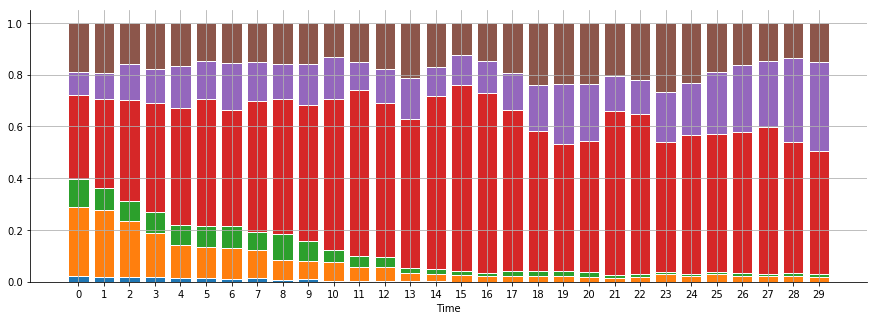

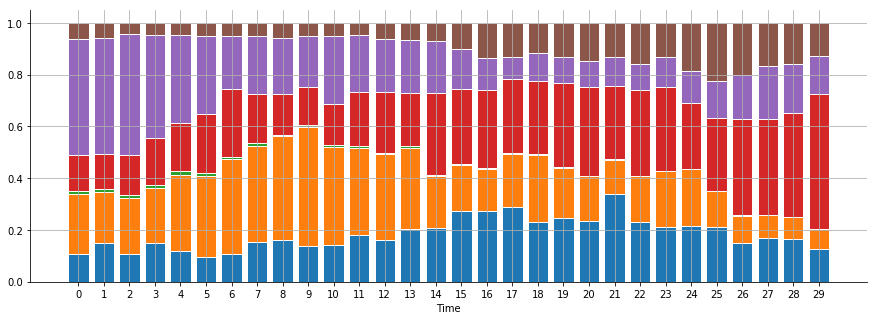

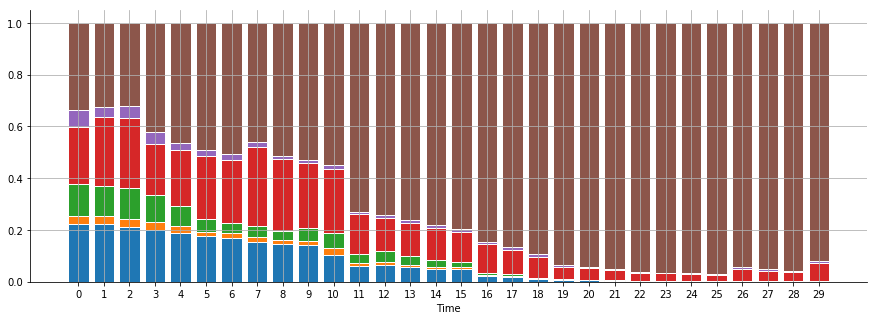

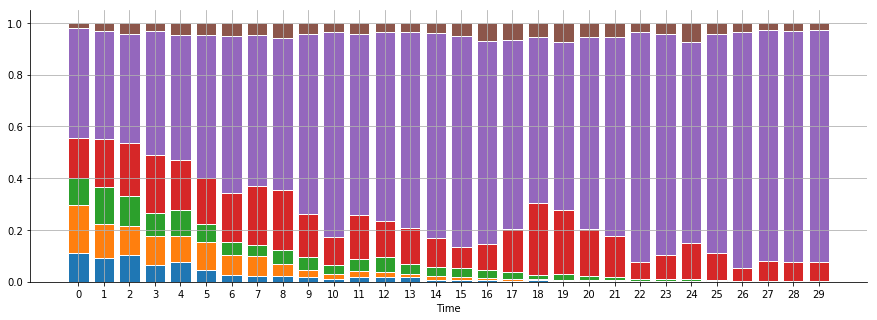

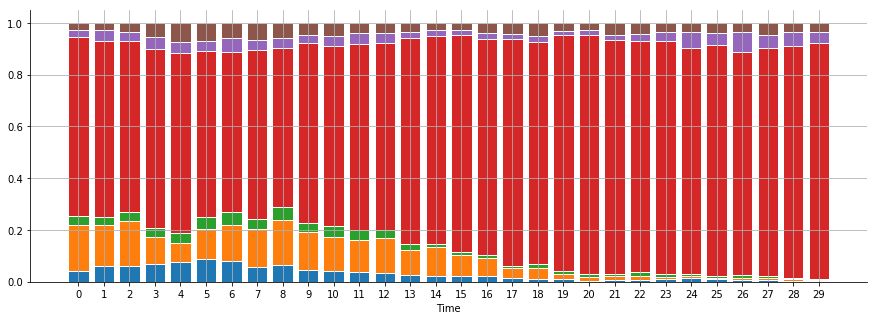

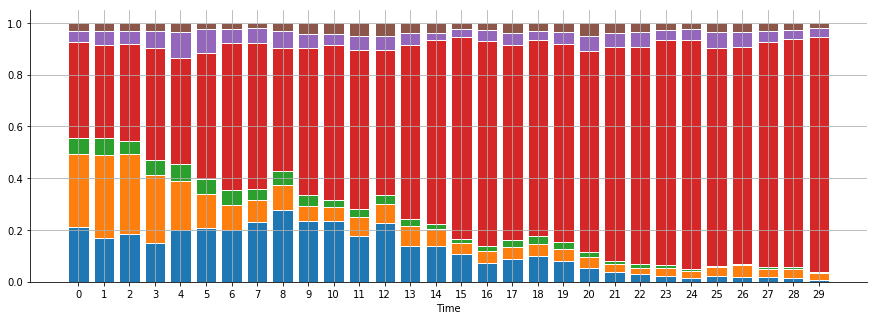

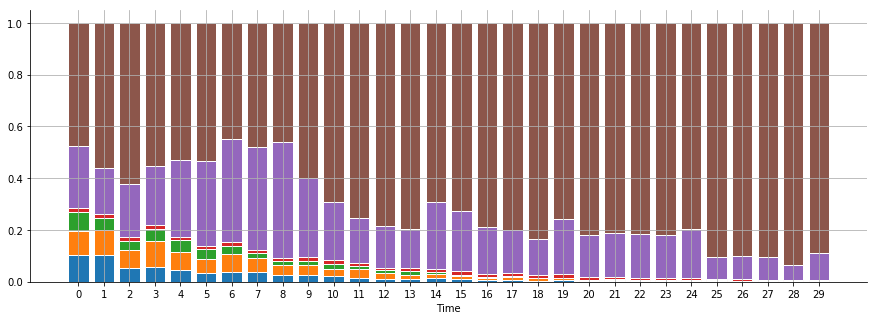

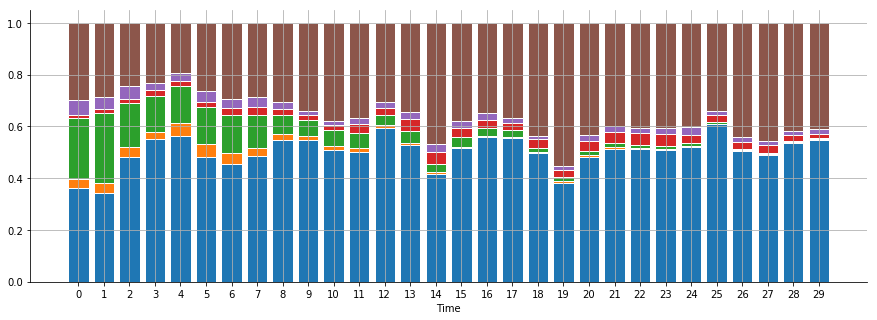

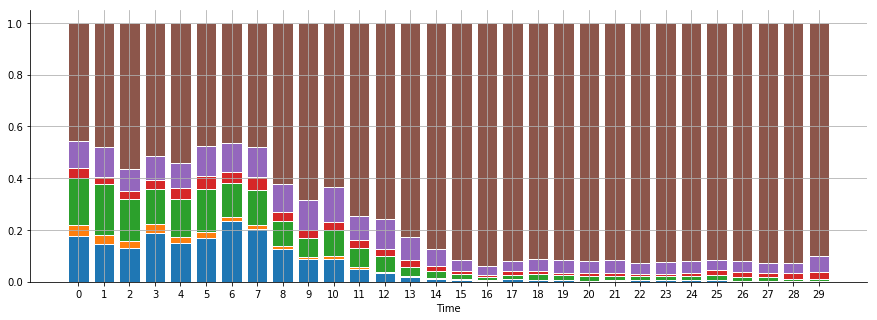

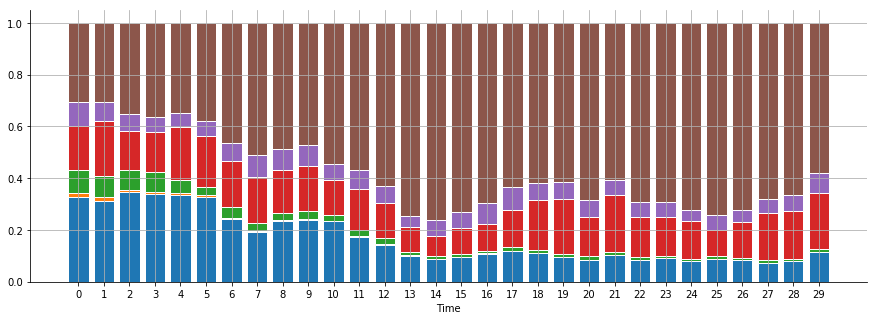

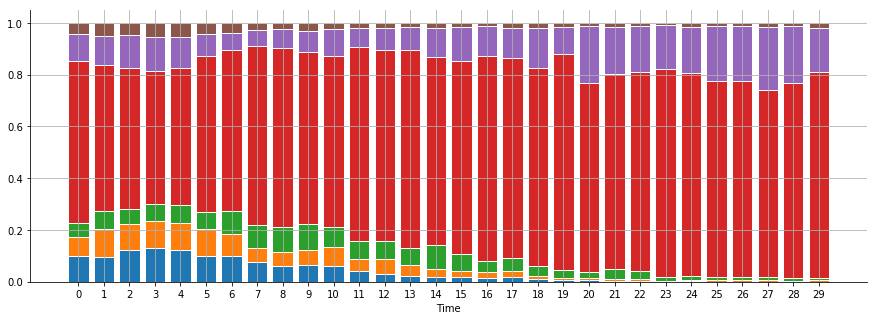

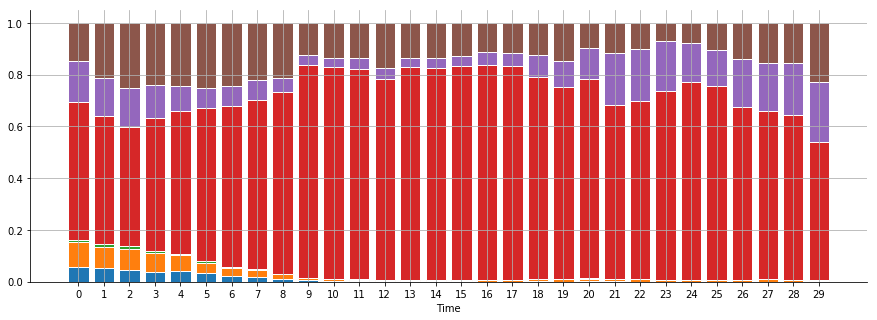

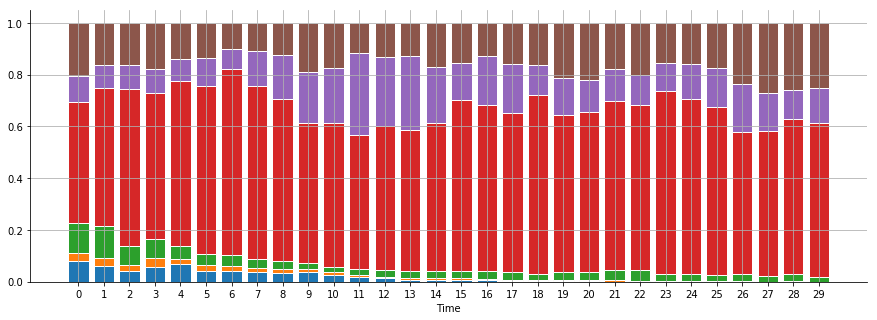

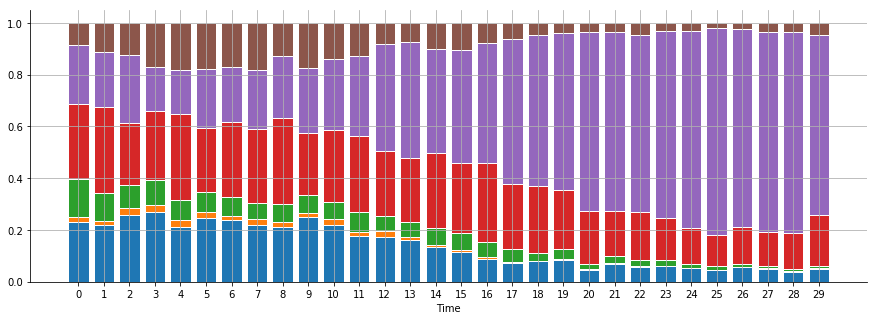

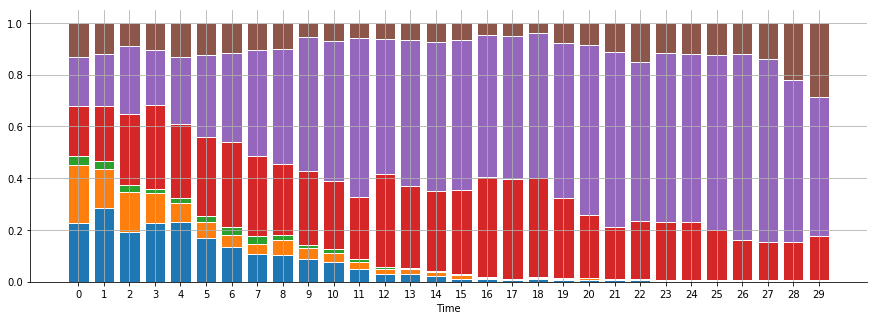

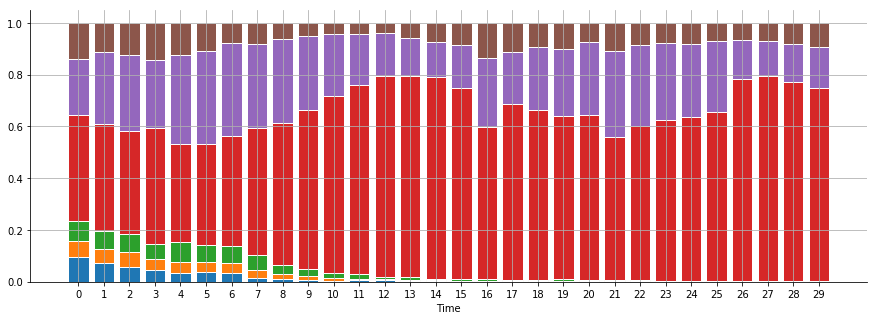

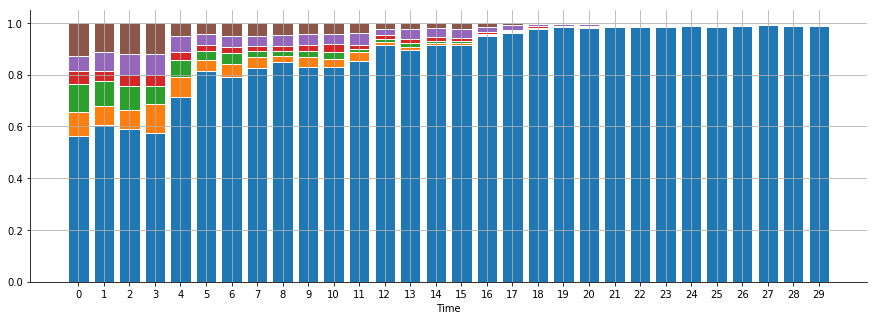

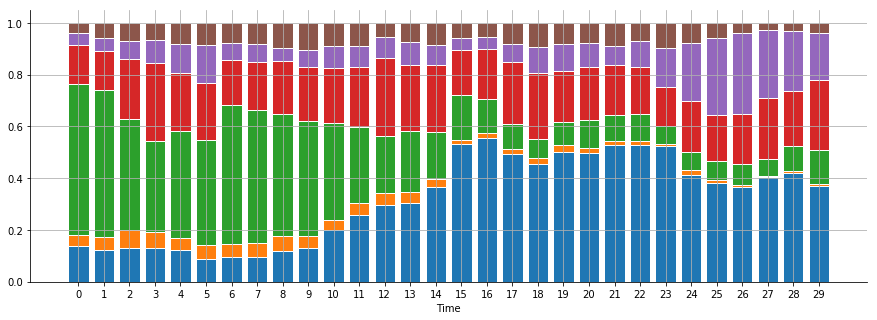

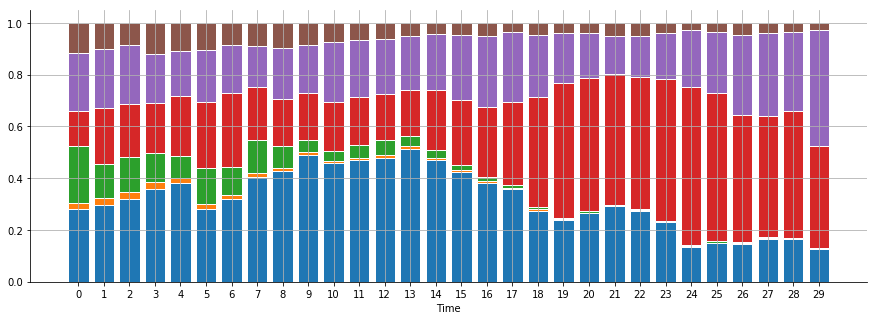

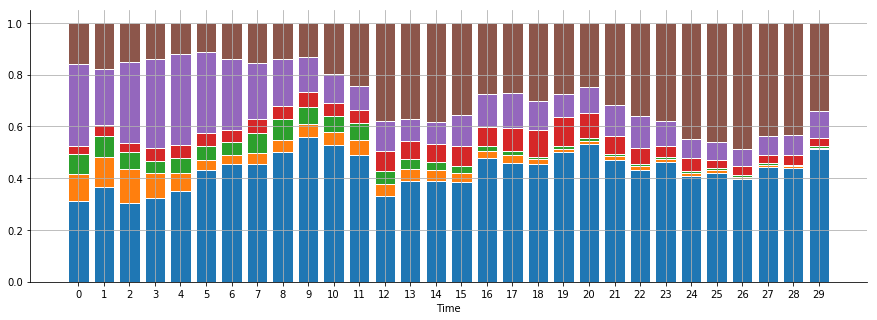

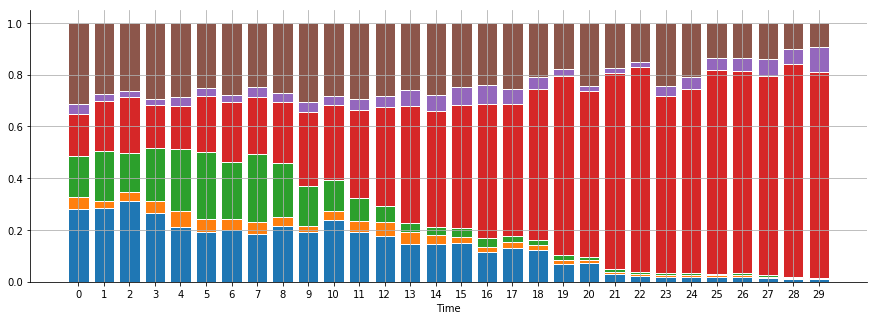

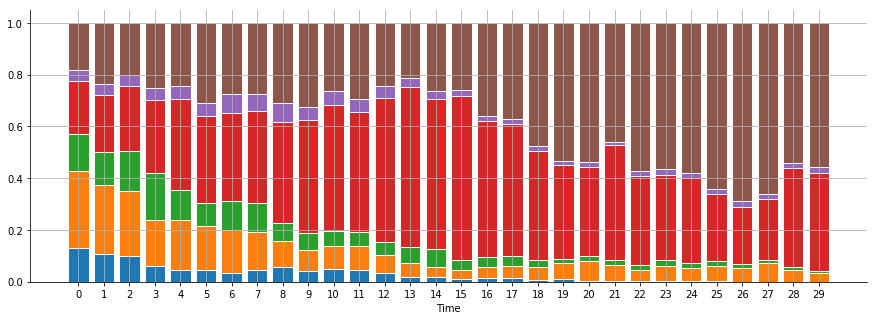

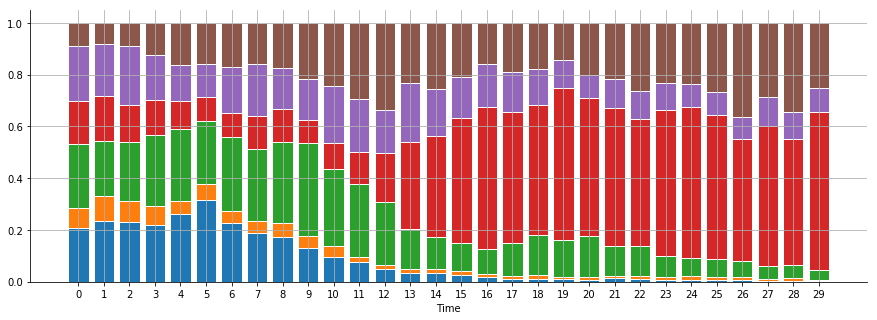

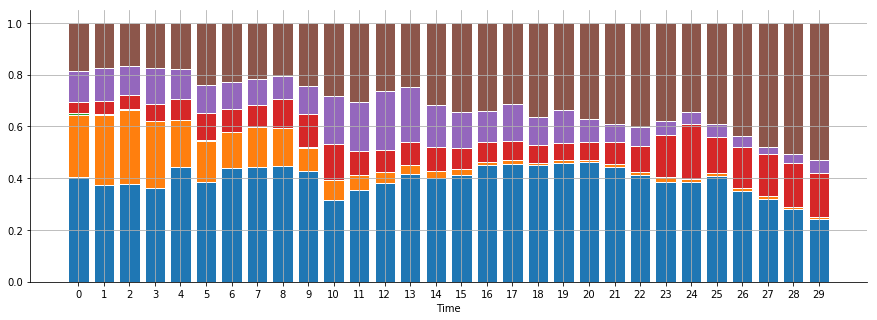

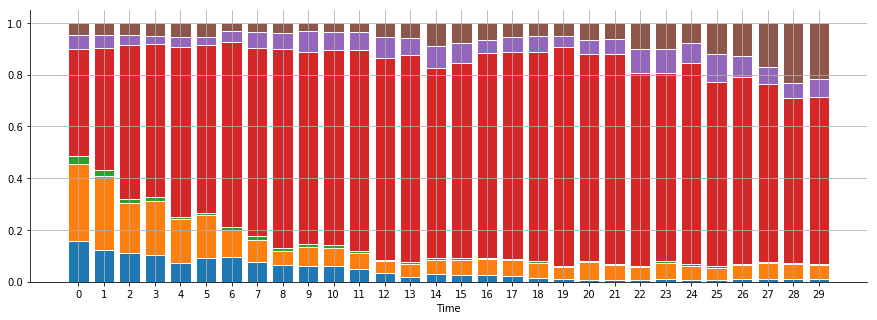

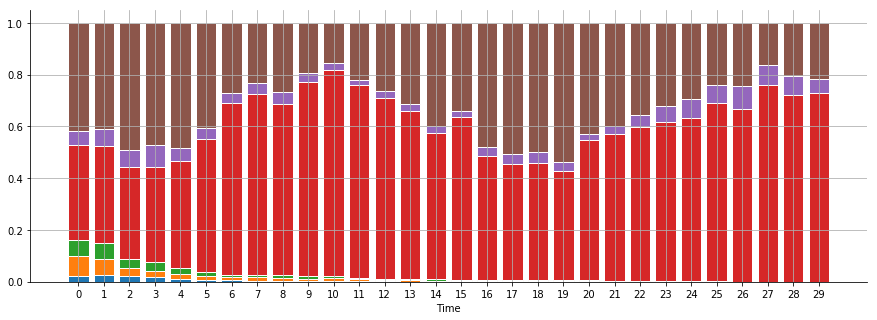

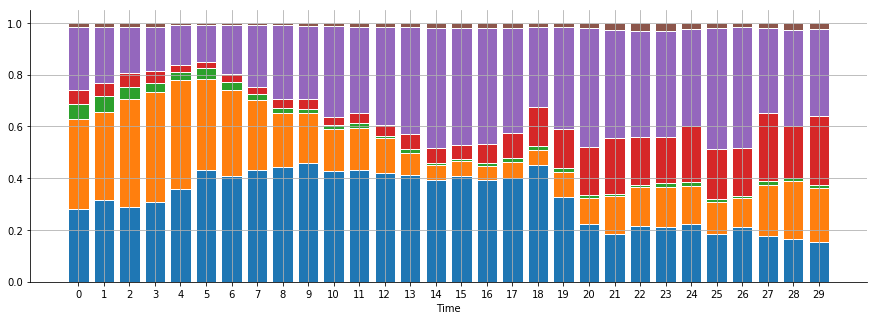

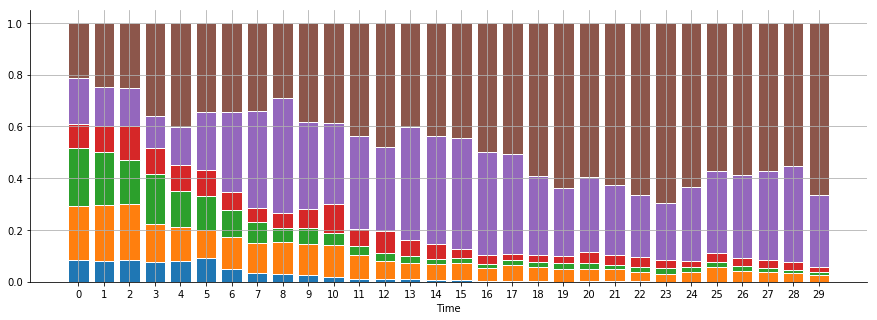

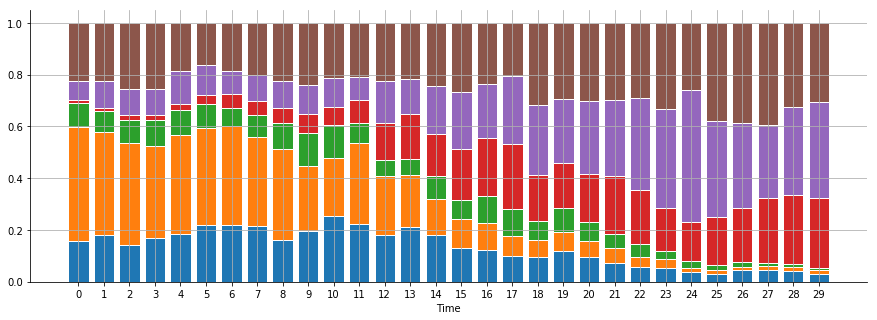

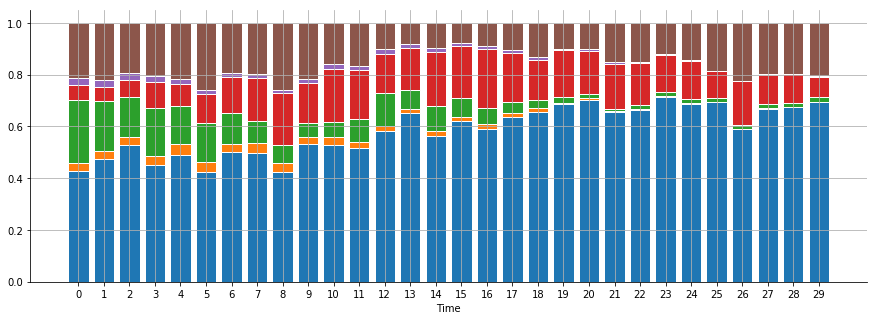

In [758]:
for i in range(0, 30):
    plot_inputs_and_obs(inputs, obs, masks, i)

# save

In [759]:
import pickle

In [788]:
c_data = {}

c_data['theta'] = theta
c_data["b"] = bs

c_data['Ytrain'] = y_train  # count
c_data['Ytest'] = y_test
c_data['Xtrain'] = x_train # ystar
c_data['Xtest'] = x_test

c_data['Vtrain'] = input_train
c_data['Vtest'] = input_test

c_data["A"] = A
c_data["g"] = g


with open("six_taxa.p", "wb") as f:
    pickle.dump(c_data, f)

# create another dataset

In [763]:
theta2 = np.array([[+1, -1, 0,0,0,0,0, 0], 
                  [+1, +1, -1, -1, -1, 0,0,0],
                  [0,0,+1, -1, -1, 0,0,0],
                  [0,0,0,+1, -1, 0, 0, 0], 
                  [+1, +1, +1, +1, +1, -1, -1, -1],
                  [0, 0, 0 ,0 ,0, +1, -1, -1], 
                  [0, 0, 0, 0, 0, 0, +1, -1]])
# get tree
root2, reference2 = convert_theta_to_tree(theta2)

b2 = np.array([0., 1, 0, 1, 1, 1, 0])
set_b(reference2, b2)
root2.print_tree()

node 4 inode 4
   node 1 inode 1
      node 0 inode 0
         node 7 taxon 0
         node 8 taxon 1
      node 2 inode 2
         node 9 taxon 2
         node 3 inode 3
            node 10 taxon 3
            node 11 taxon 4
   node 5 inode 5
      node 12 taxon 5
      node 6 inode 6
         node 13 taxon 6
         node 14 taxon 7


In [764]:
n_taxon2 = theta2.shape[1]

w2 = np.ones(n_taxon2)

# ilr transformation
n_plus2, n_minus2 = get_n_plus_and_n_minus(theta2, w2)
psi2 = get_psi(theta2, n_plus2, n_minus2)

In [765]:
# calcualte probs
n_inode2 = theta2.shape[0]
n_node2 = theta2.shape[0] + theta2.shape[1]
p_i2 = get_p_i(n_inode2, root2)
p_j_given_i2 = get_p_j_given_i(n_node2, n_inode2, root2)
n_taxon2 = theta2.shape[1]

In [778]:
# set dynamics parameters
np.random.seed(10)
g2 = np.random.randn(n_inode2) * 0.01
A2 = np.random.randn(n_inode2, n_node2) * 0.1

In [779]:
x_train2 = []
y_train2 = []
input_train2 = []

init_variance = 1
transition_sigma = 0.2

for i in range(n_train):
    # init y_star
    x = np.random.randn(n_taxa) * init_variance
    x = np.exp(x) / np.sum(np.exp(x))
    init_y_star = ilr_transform(x, w, theta, n_plus, n_minus)
    
    Y, X, C = simulate(root, psi, g, A, p_i, p_j_given_i, N, n_days, init_y_star, transition_sigma)
    C_with_date_stamp2 = np.concatenate([days, C], axis=-1)
    x_train2.append(Y)
    y_train2.append(C_with_date_stamp)
    input_train2.append(days)
    
x_test2 = []
y_test2 = []
input_test2 = []
for i in range(n_test):
     # init y_star
    x = np.random.randn(n_taxa) * init_variance
    x = np.exp(x) / np.sum(np.exp(x))
    init_y_star = ilr_transform(x, w, theta, n_plus, n_minus)
    
    Y, X, C = simulate(root, psi, g, A, p_i, p_j_given_i, N, n_days, init_y_star, transition_sigma)
    C_with_date_stamp = np.concatenate([days, C], axis=-1)
    x_test2.append(Y)
    y_test2.append(C_with_date_stamp)
    input_test2.append(days)

In [780]:
obs_train2, obs_test2 = [], []
for y in y_train2:
    days, counts = y[:, :1], y[:, 1:]
    perc = counts / counts.sum(axis=-1, keepdims=True)
    obs_train2.append(np.concatenate([days, perc], axis=-1))
for y in y_test2:
    days, counts = y[:, :1], y[:, 1:]
    perc = counts / counts.sum(axis=-1, keepdims=True)
    obs_test2.append(np.concatenate([days, perc], axis=-1))
extra_inputs_train2 = [None for _ in range(len(obs_train2))]
extra_inputs_test2 = [None for _ in range(len(obs_test2))]

hidden_train2, hidden_test2 = x_train2, x_test2

hidden_train2, hidden_test2, obs_train2, obs_test2, input_train2, input_test2, _mask_train2, _mask_test2, time_interval_train2, time_interval_test2, extra_inputs_train2, extra_input_test2 = \
    interpolate_data(hidden_train2, hidden_test2, obs_train2, obs_test2, input_train2, input_test2,
                     extra_inputs_train2, extra_inputs_test2, interpolation_type=None)

masks2 = _mask_train2 + _mask_test2
obs2 = obs_train2 + obs_test2
inputs2 = input_train2 + input_test2

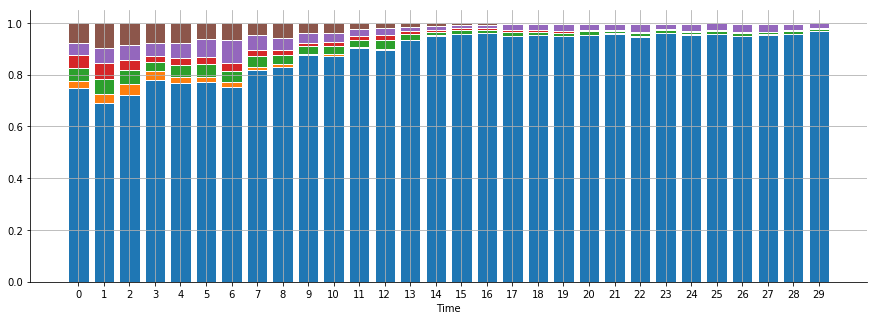

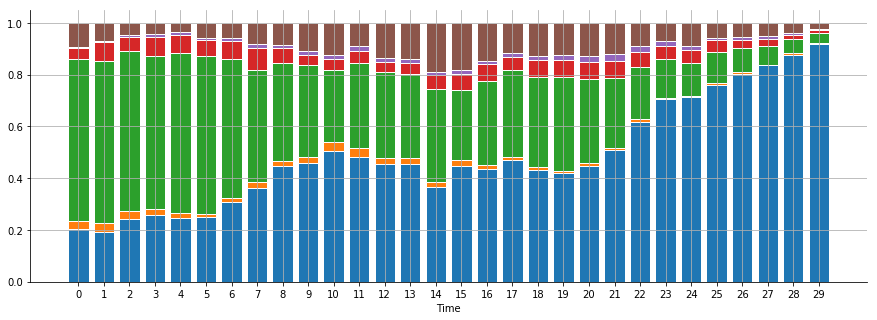

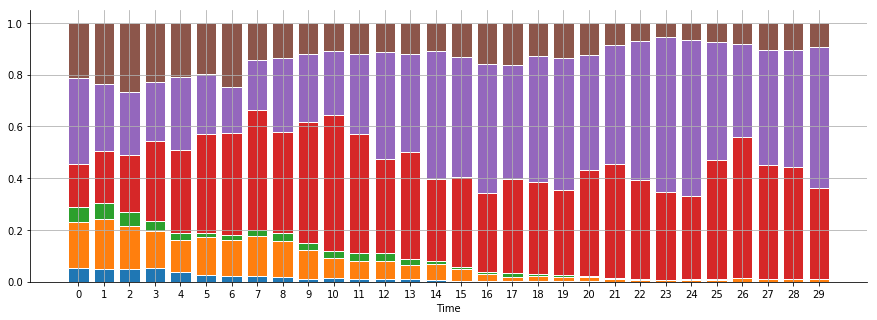

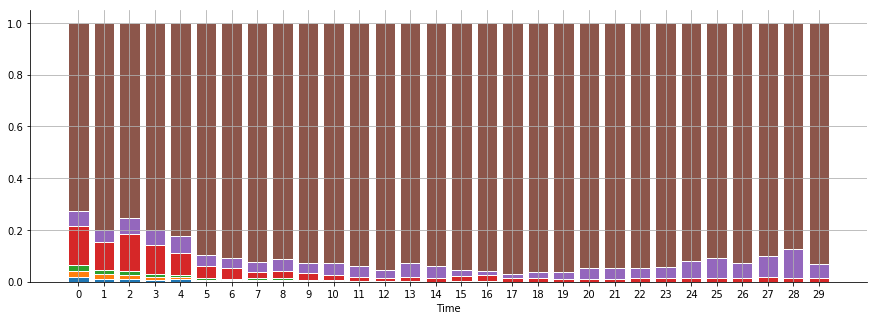

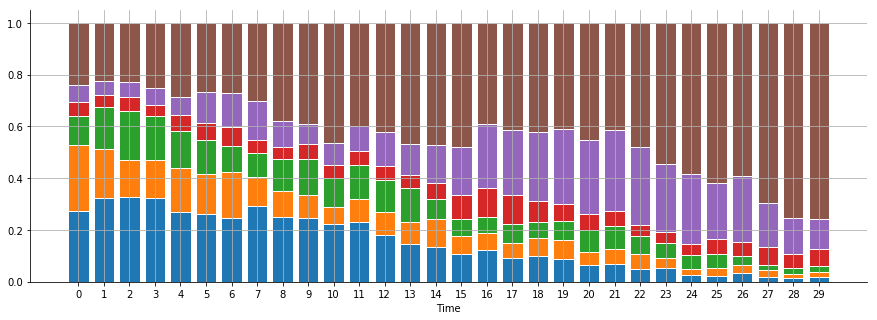

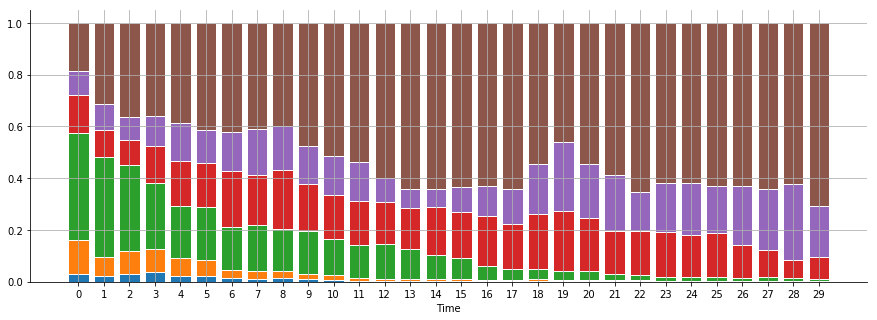

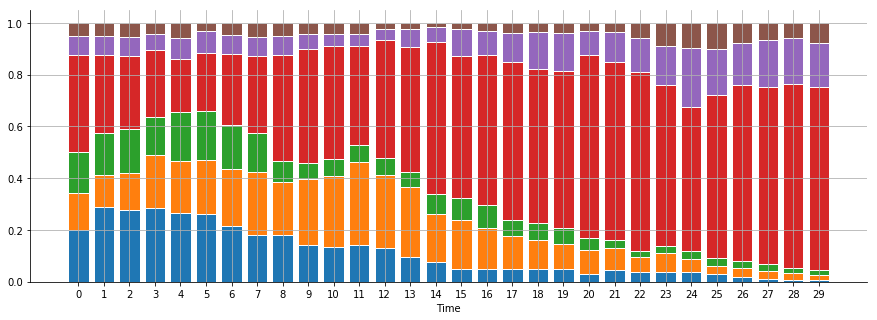

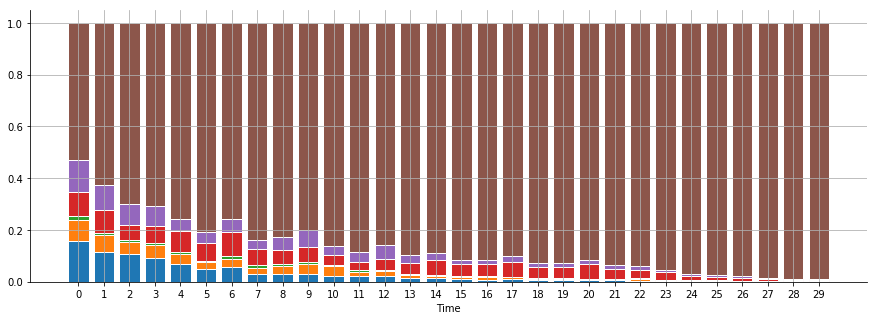

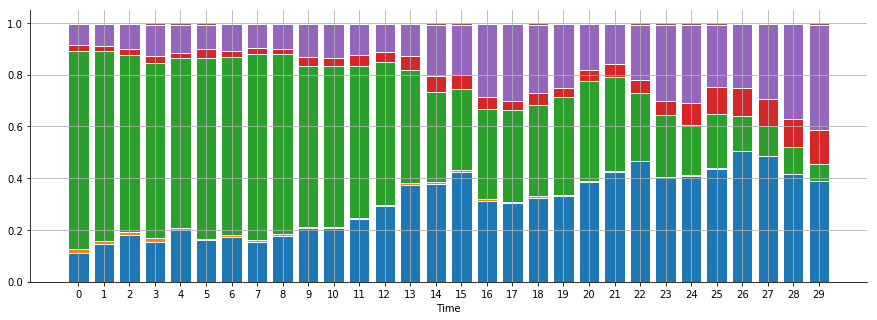

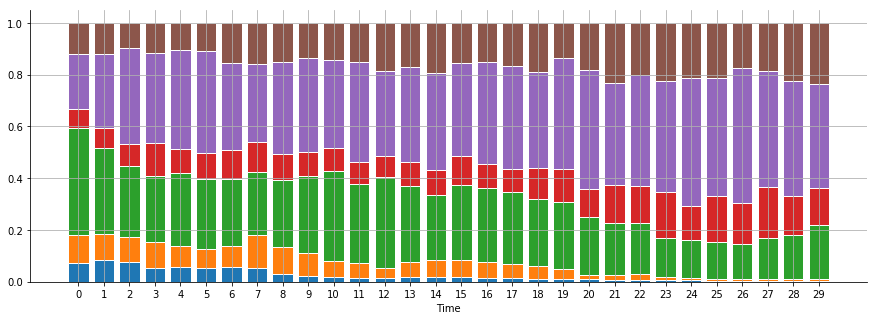

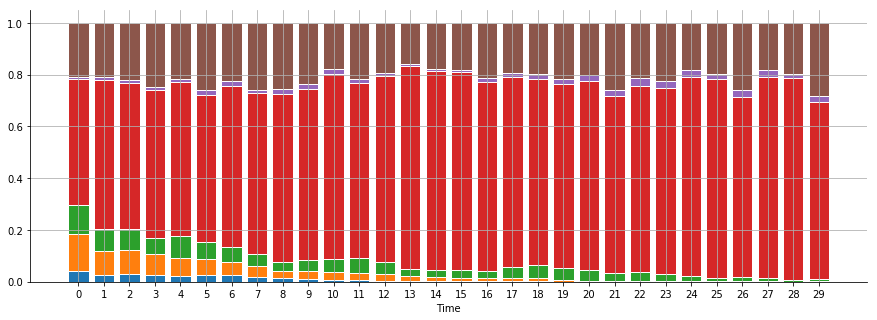

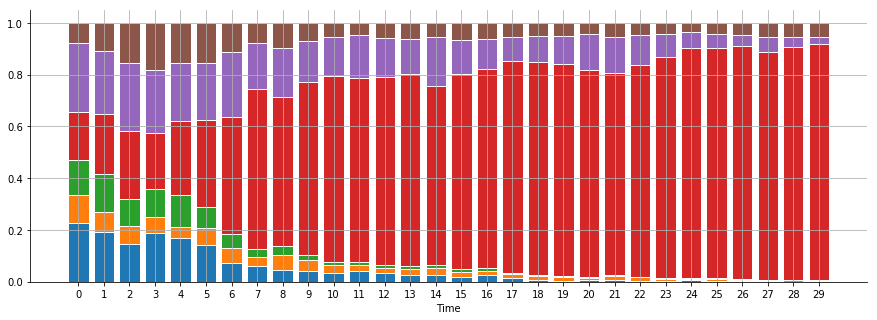

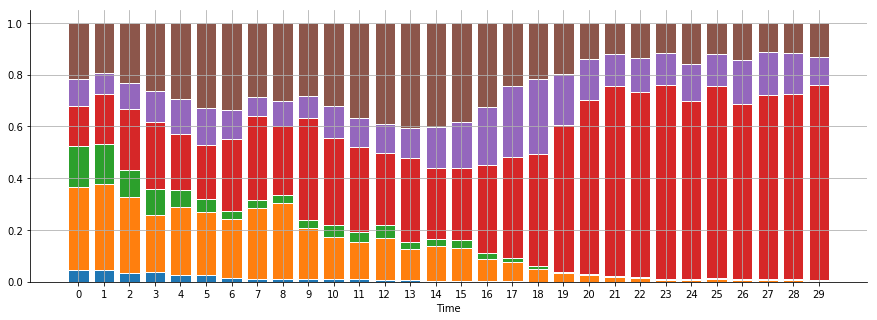

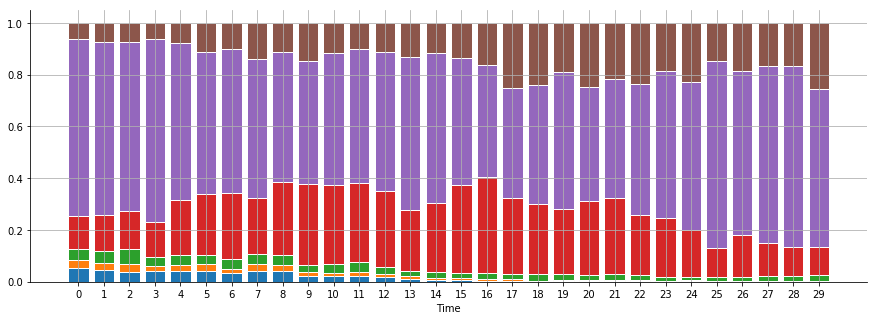

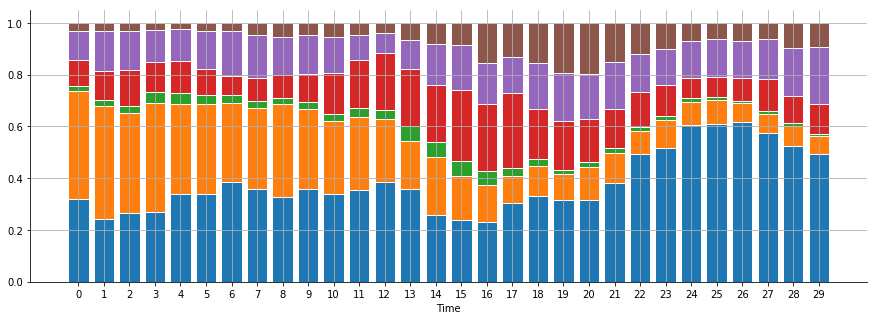

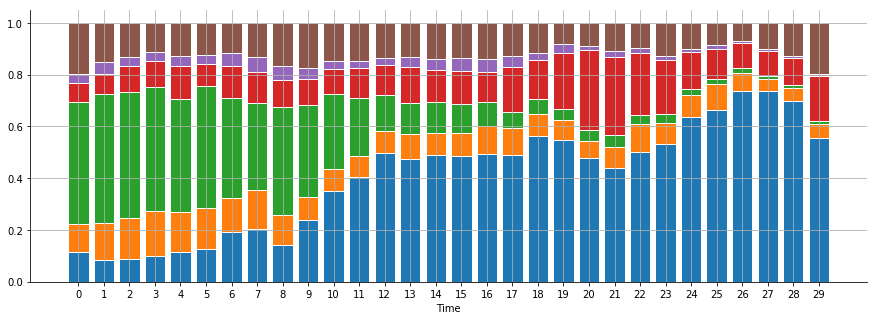

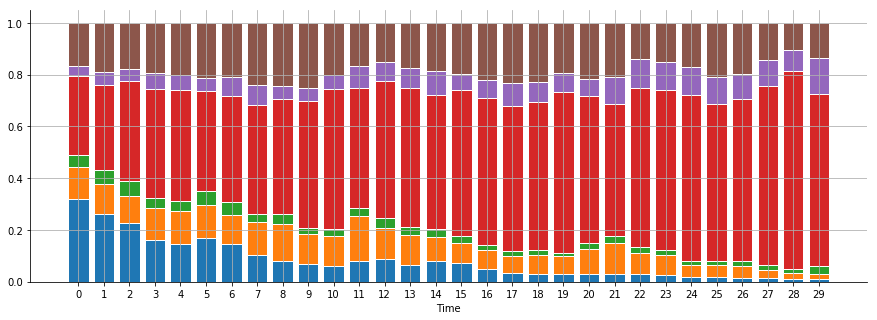

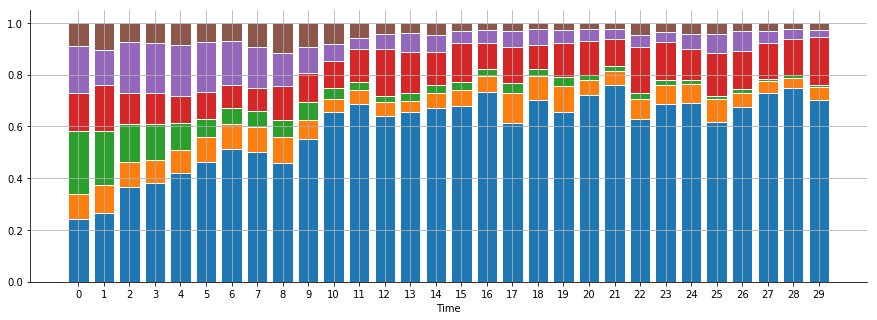

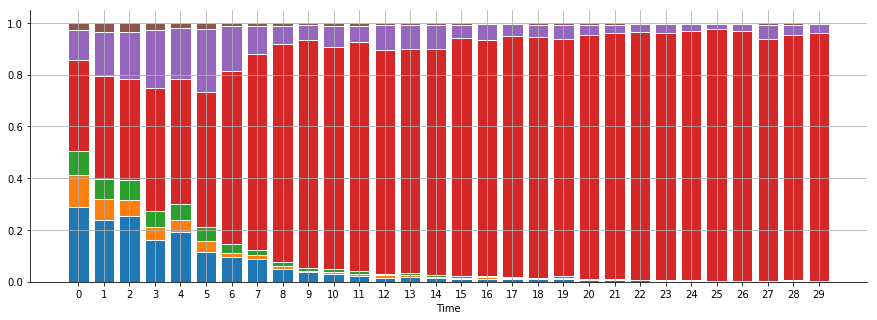

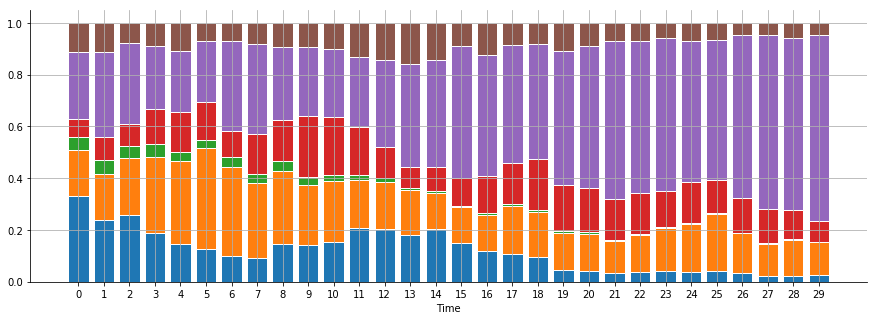

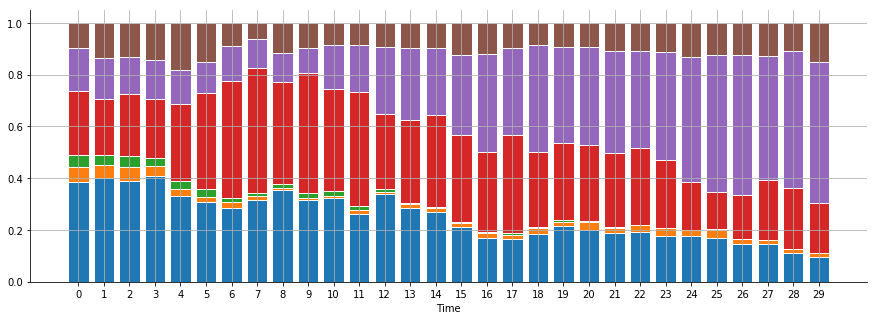

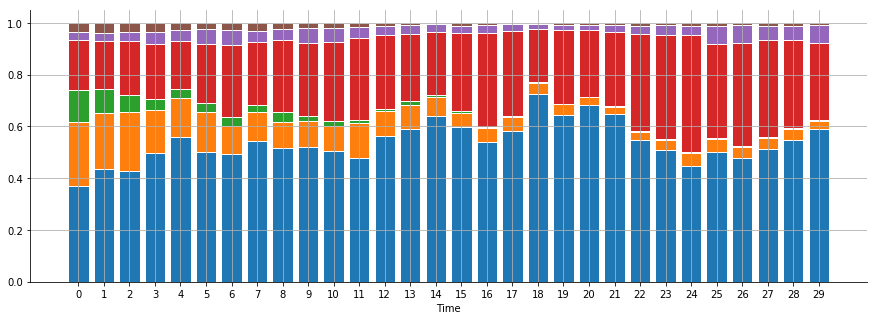

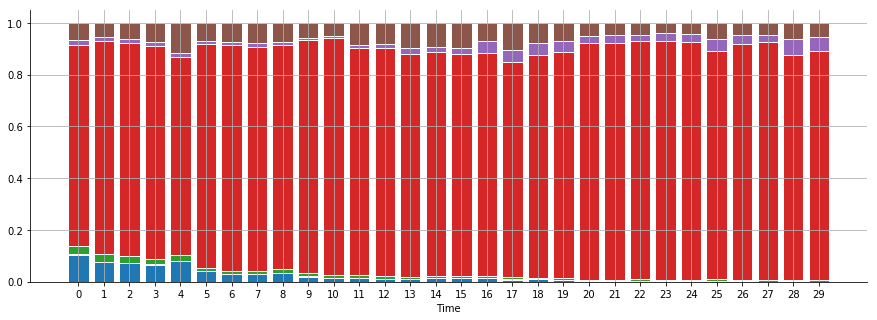

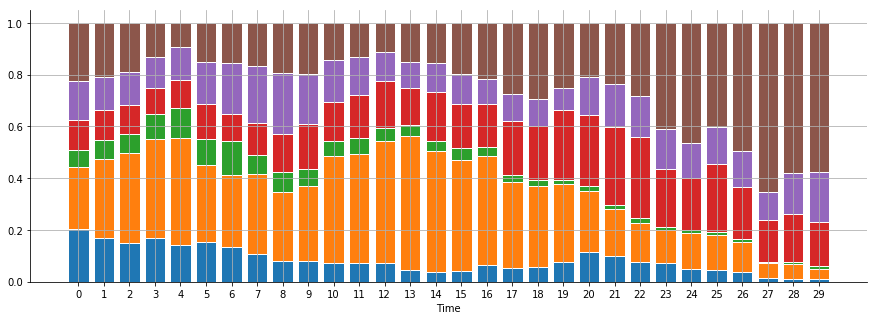

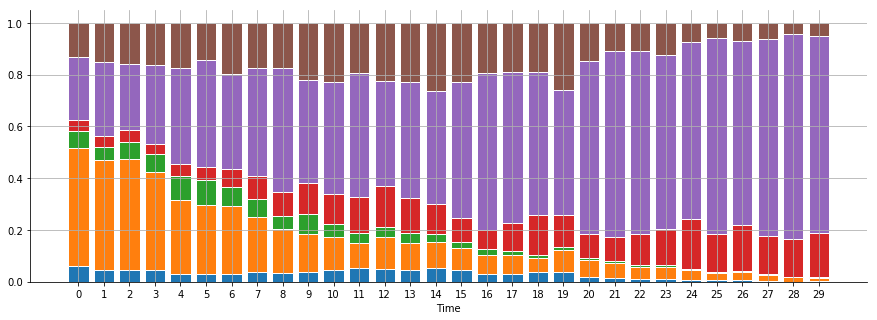

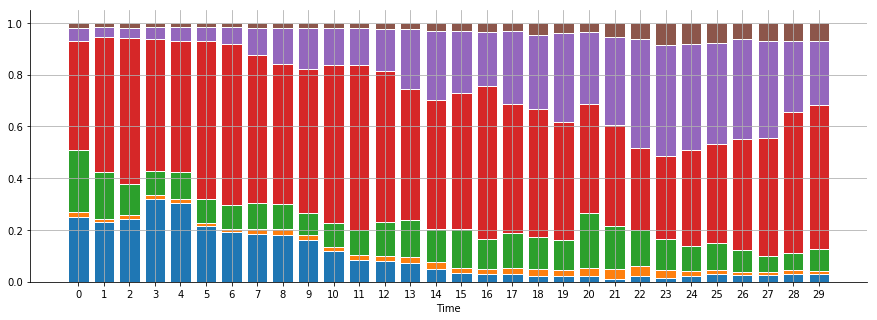

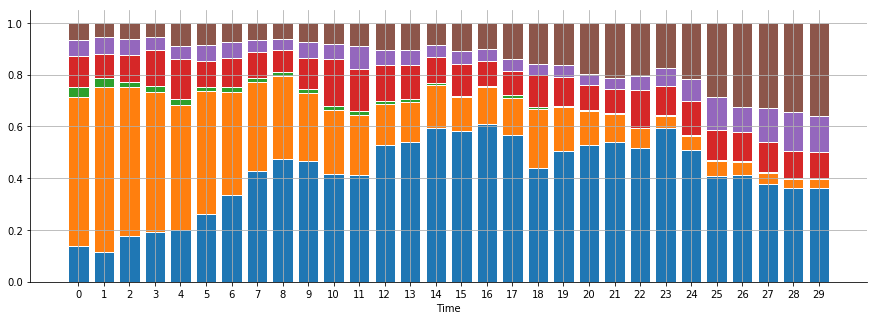

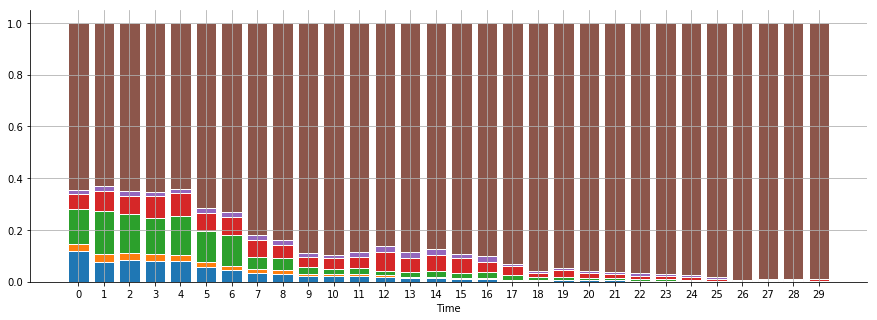

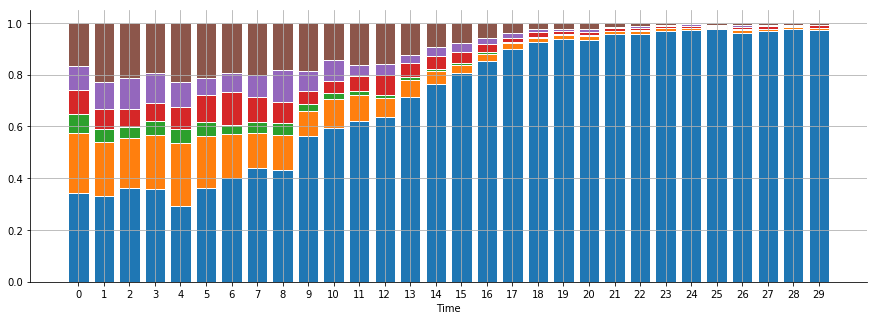

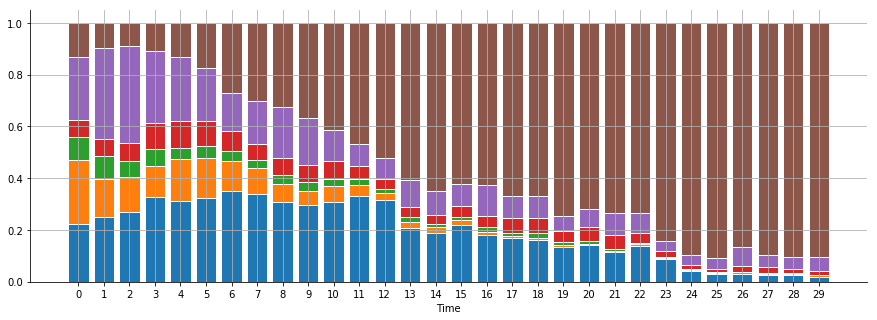

In [781]:
for i in range(0, 30):
    plot_inputs_and_obs(inputs2, obs2, masks2, i)

# save

In [790]:
c_data2 = {}

c_data2['theta'] = theta2
c_data2["b"] = b2

c_data2['Ytrain'] = y_train2  # count
c_data2['Ytest'] = y_test2
c_data2['Xtrain'] = x_train2 # ystar
c_data2['Xtest'] = x_test2

c_data['Vtrain'] = input_train2
c_data['Vtest'] = input_test2

c_data["A"] = A2
c_data["g"] = g2


with open("eight_taxa.p", "wb") as f:
    pickle.dump(c_data2, f)

In [791]:
b2

array([0., 1., 0., 1., 1., 1., 0.])